# Tabular Playground Series - October 2021

In this notebook, we do some prelimary work on the raw data provided for the playground competition. In particular, we do the following:

1. Reduce memory usage
2. Store in `.feather` format for quicker loading
3. Perform adversarial validation on the training/test sets

It is important to save memory since our models will run very slowly or even throw errors if we use too much memory while training. We will solely use decision forest libraries which generally require the training data to be loaded in to memory so any space we can save is a good thing.

In [1]:
# Global variables for testing changes to this notebook quickly
RANDOM_SEED = 0
NUM_FOLDS = 3
NUM_TREES = 500
EARLY_STOP = 25

In [2]:
import numpy as np
import pandas as pd
import time
import os
import pyarrow
import gc

# Model for validation
from lightgbm import LGBMClassifier
import lightgbm as lgbm

# Model evaluation
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_auc_score, mean_squared_error

# Plotting
import matplotlib
from matplotlib import pyplot as plt

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

# 1. Memory Usage Reduction

This month's data has over 200 features and combined 1.5 million rows. We will speed up our analysis by downcasting the data wherever possible.

In [3]:
# Print the paths to all of the output files
for dirname, _, filenames in os.walk('..\data'):
    for filename in filenames:
        if filename.endswith('.csv'):
            print(os.path.join(dirname, filename))

..\data\sample_submission.csv
..\data\test.csv
..\data\train.csv


## 1.1 Loading CSV data

In [4]:
%%time

# Load original .csv data
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

# Save feature columns names for later
features = [x for x in train.columns if x not in ['id', 'target']]

Wall time: 43.6 s


## 1.2 Helper Function

In [5]:
# Downcast float/int datatypes
def reduce_memory_usage(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col, dtype in df.dtypes.iteritems():
        if dtype.name.startswith('int'):
            df[col] = pd.to_numeric(df[col], downcast ='integer')
        elif dtype.name.startswith('float'):
            df[col] = pd.to_numeric(df[col], downcast ='float')
        
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

In [6]:
%%time

# Reduce memory and save as .feather
train = reduce_memory_usage(train)
train.to_feather('../data/train.feather')
test = reduce_memory_usage(test)
test.to_feather('../data/test.feather')

Mem. usage decreased to 963.21 Mb (56.0% reduction)
Mem. usage decreased to 481.13 Mb (55.9% reduction)
Wall time: 1min 39s


# 2. Feather Format

We saved our data in `.feather` format for quicker loading later. This format saves the datatypes so we won't have to do our memory reduction again and we can work solely with feather for the remaining notebooks.

In [7]:
# Check datatypes
train.dtypes.value_counts()

float32    240
int8        46
int32        1
dtype: int64

In [8]:
%%time

# Load feather data
train = pd.read_feather('../data/train.feather')
test = pd.read_feather('../data/test.feather')

train.dtypes.value_counts()

Wall time: 1.52 s


float32    240
int8        46
int32        1
dtype: int64

We see that it takes under two seconds to load our `.feather` data as opposed to 45s with the original .csv files.

# 3. Adversarial Validation

The idea behind adversarial validation is that if there are differences in the training and test data distributions an algorithm like LightGBM should be able to find these differences and use them to distinguish the two sets. So we create a classification problem where we predict whether a sampling of the data comes from the training or test sets. Ideally, we hope to see ~.5 AUC which would mean that our algorithm couldn't find meaningful distinctions between the test and training data.

In [9]:
lightgbm_params = dict(
    n_estimators = NUM_TREES,
    random_state = RANDOM_SEED,
)

In [10]:
# Performs adversarial validation with LightGBM
def lgbm_validation(train, test, verbose = True):
    
    scores = np.zeros(NUM_FOLDS)
    
    # Sampling
    X = train.sample(n=200000, random_state=0)
    X_test = test.sample(n=200000, random_state=0)
    
    # Preparing data
    X = X.set_index('id').drop('target', axis='columns')
    X_test = X_test.set_index('id')
    
    # New "meta" data
    Xa = X.append(X_test)
    Xa['test'] = [0] * len(X) + [1] * len(X_test)
    
    # Cross validation scheme
    skf = StratifiedKFold(NUM_FOLDS, shuffle = True, random_state = RANDOM_SEED) 
    for fold, (train_idx, valid_idx) in enumerate(skf.split(Xa, Xa['test'])):
        
        # Training and Validation Sets
        X_train, y_train = Xa[features].iloc[train_idx], Xa['test'].iloc[train_idx]
        X_valid, y_valid = Xa[features].iloc[valid_idx], Xa['test'].iloc[valid_idx]
        

        start = time.time()

        # Model with params
        model = LGBMClassifier(**lightgbm_params)

        model.fit(
            X_train, y_train,
            eval_set = [(X_valid, y_valid)],
            eval_metric = 'auc',
            early_stopping_rounds = EARLY_STOP,
            verbose = False,
        )
        
        # Validation AUC
        scores[fold] = roc_auc_score(
            y_true = y_valid, 
            y_score = model.predict_proba(X_valid)[:,1]
        )

        end = time.time()

        print(f"LightGBM Fold {fold} (AUC):", 
              round(scores[fold], 6), " ",
              str(round(end-start, 3))+"s")

    print("\nLightGBM (Avg):", round(scores.mean(), 6))
    
    # return a fitted model and training data for feature importances
    return model

In [11]:
%%time

fitted_model = lgbm_validation(train, test)

LightGBM Fold 0 (AUC): 0.982069   61.022s
LightGBM Fold 1 (AUC): 0.981821   61.263s
LightGBM Fold 2 (AUC): 0.98216   61.469s

LightGBM (Avg): 0.982017
Wall time: 3min 6s


We see very high AUC values indicating that our model does a good job distinguishing the training and test data.

# Feature Importance

We can examine the feature importances to see which features contributed the most to distinguishing the training and test sets.

### Importance Type: Split

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

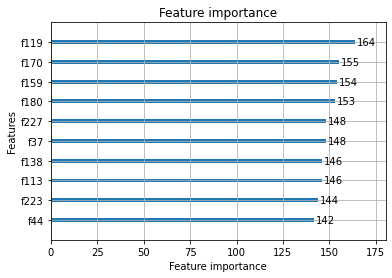

In [12]:
lgbm.plot_importance(
    booster = fitted_model,
    importance_type = "split",
    max_num_features = 10,
)

### Importance Type: Gain

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

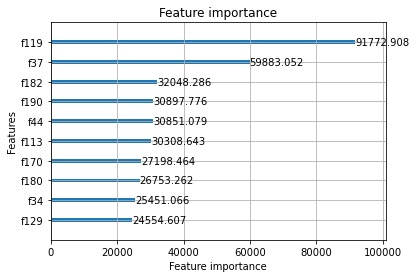

In [13]:
lgbm.plot_importance(
    booster = fitted_model,
    importance_type = "gain",
    max_num_features = 10,
)